In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
from sklearn.utils import resample

%matplotlib inline
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

pd.options.display.max_columns = None
pd.options.display.max_rows = 100
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
from sklearn.linear_model import LogisticRegression


# from sklearn.preprocessing import OrdinalEncoder
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression 
# from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler 



In [ ]:
df_raw_accepted = pd.read_csv('accepted_2007_to_2018Q4.csv.gz')
df_raw_rejected = pd.read_csv('rejected_2007_to_2018Q4.csv.gz')

In [2]:
'''
For applications prior to November 5, 2013 the risk score is the borrower's FICO score. 
For applications after November 5, 2013 the risk score is the borrower's Vantage score.
'''

def data_process(df_accepted,df_rejected):
    
    accepted = df_accepted.copy()
    rejected = df_rejected.copy()
    
    # Processing accepted data 
    accepted = accepted[['loan_amnt', 'purpose', 'dti',
       'zip_code', 'addr_state', 'emp_length', 'issue_d',
       'loan_status', 'last_fico_range_high','last_fico_range_low']]
    
    accepted['issue_d'] = pd.to_datetime(accepted['issue_d'])
    accepted['app_year'] = accepted['issue_d'].dt.year
    accepted['app_month'] = accepted['issue_d'].dt.month

    accepted['risk_score'] = (accepted['last_fico_range_high'] + accepted['last_fico_range_low'])/2
    accepted = accepted.drop(columns = ['issue_d','last_fico_range_high','last_fico_range_low'])

#     if reverse = False:
#         accepted = accepted.replace({'loan_status' : { 'Charged Off' : 'rejected', 'Late (16-30 days)' : 'rejected', 
#                                        'Late (31-120 days)' : 'rejected',
#                                        'Does not meet the credit policy. Status:Charged Off' : 'rejected',
#                                        'Fully Paid' : 'accepted', 'Current' : 'accepted',
#                                        'In Grace Period' : 'accepted',
#                                        'Does not meet the credit policy. Status:Fully Paid' : 'accepted'}})

    accepted['loan_status'] =1
            
    
    # Processing rejected data 
    rejected = rejected.iloc[:,1:9]
    rejected = rejected.rename(columns={"Amount Requested": "loan_amnt", "Application Date": "app_date", "Loan Title": "purpose",
                             "Risk_Score": "risk_score", "Debt-To-Income Ratio": "dti", "Zip Code": "zip_code",
                             "State": "addr_state", "Employment Length": "emp_length"})
    rejected['loan_status'] = 0
    
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*consolidation.*$)', 'debt_consolidation')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*loan.*$)', 'debt_consolidation')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*debt.*$)', 'debt_consolidation')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*card.*$)', 'credit_card')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*credit.*$)', 'credit_card')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*house.*$)', 'house')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*business.*$)', 'small_business')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*car.*$)', 'car')
    rejected['purpose'] = rejected['purpose'].str.replace(r'(^.*education.*$)', 'education')
    
    
    rejected['purpose'] = np.where(rejected['purpose'].isin(['house', 'credit_card', 'major_purchase', 'debt_consolidation',
       'other', 'moving', 'small_business', 'home_improvement',
       'vacation', 'medical', 'renewable_energy', 'car', 'wedding']), rejected['purpose'], 'other')

    rejected['app_date'] = pd.to_datetime(rejected['app_date'])
    rejected['app_year'] = rejected['app_date'].dt.year
    rejected['app_month'] = rejected['app_date'].dt.month

    rejected = rejected.drop(columns = 'app_date')
    
    rejected['dti'] = rejected['dti'].str.replace('%','')
    
    

    
    # Merge accepted and rejected data for later process
    df_processed = pd.concat([accepted, rejected], sort=True)
    
    #Drop column with no meaning
    df_processed=df_processed.drop(['Unnamed: 0.1'], axis=1)
    
    #drop rows with NA in 
    df_processed=df_processed.dropna(subset=['app_month', 'app_year'])

    #Drop zip Code
    df_processed=df_processed.drop(['zip_code'],axis=1)
    
    # Convert categorical to numerical-- 10 means more than 10 years 
    df_processed['emp_length'] = df_processed['emp_length'].str.extract('(\d+)')


    # Missing Values: risk_score, emp_length, dti
    df_processed['emp_length'] = df_processed['emp_length'].fillna(0)
    df_processed['emp_length'] = df_processed['emp_length'].astype(int)
    df_processed['risk_score'] = df_processed['risk_score'].fillna(0)
    df_processed['dti'] = df_processed['dti'].fillna(0)
    df_processed['dti'] = df_processed['dti'].astype(float)
    
    df_processed = df_processed.drop(['purpose'], axis = 1)
    df_processed = pd.get_dummies(df_processed)
    
    
    return df_processed


### Handle Inbalanced data by downsampling the majority class (which is the rejected).

In [5]:
#reject is the majority class. downsample reject to treat the imbalanced classification problem. 

reject_downsampled = resample(df_raw_rejected,
                                replace = False, # sample without replacement
                                n_samples = len(df_raw_accepted), # match minority n
                                random_state = 27) # reproducible results
reject_downsampled.to_csv('reject_downsampled.csv')



NameError: name 'df_raw_rejected' is not defined

In [6]:
reject_downsampled=pd.read_csv('reject_downsampled.csv')

### Split train and test set. Test set will be used for testing result of the best model selected in the future.  

In [4]:
# train_set_from_reject_downsampled= reject_downsampled.sample(frac=0.75, random_state=0)
# test_set_from_reject_downsampled = reject_downsampled.drop(train_set_from_reject_downsampled.index)

In [ ]:
# train_set_from_reject_downsampled.to_csv('train_set_from_reject_downsampled.csv')
# test_set_from_reject_downsampled.to_csv('test_set_from_reject_downsampled.csv')

In [3]:
train_set_from_reject_downsampled=pd.read_csv('train_set_from_reject_downsampled.csv')
test_set_from_reject_downsampled=pd.read_csv('test_set_from_reject_downsampled.csv')

In [6]:
# train_set_from_accepted_raw= df_raw_accepted.sample(frac=0.75, random_state=0)
# test_set_from_accepted_raw = df_raw_accepted.drop(train_set_from_accepted_raw.index)

In [7]:
# train_set_from_accepted_raw.to_csv('train_set_from_accepted_raw.csv')
# test_set_from_accepted_raw.to_csv('test_set_from_accepted_raw.csv')

In [4]:
train_set_from_accepted_raw=pd.read_csv('train_set_from_accepted_raw.csv')
test_set_from_accepted_raw=pd.read_csv('test_set_from_accepted_raw.csv')

C:\Users\Laptop2\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Laptop2\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1,20,50,60,119,130,131,132,135,136,137,140,146,147,148) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Work on the train set for model selection

In [ ]:
# df_processed.isnull().sum()

In [5]:
df_processed = data_process(train_set_from_accepted_raw, train_set_from_reject_downsampled)

In [11]:
df_processed.to_csv('df_processed.csv')

In [ ]:
df_processed=pd.read_csv('df_processed.csv')

In [ ]:
# total = df_processed.isnull().sum().sort_values(ascending=False)
# percent = (df_processed.isnull().sum()/df_processed.isnull().count()).sort_values(ascending=False)
# missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_data

In [6]:
# # The predicted column is "loan_status" , split the data into training and test sets.
x_m = df_processed.drop(['loan_status'], axis=1)
y_m = df_processed.loc[:,'loan_status']
X_train, X_test, y_train, y_test = train_test_split(x_m, y_m, test_size=0.2, random_state=42)

 <p><a name="ml"></a></p>
 
 # Machine Learning
 
- Unsupervised Machine Learning  
    - <a href="#kmeans">K Means</a><br> 
    
- Supervised Machine Learning      
    - <a href="#decision">Decision Tree</a><br>
    - <a href="#rf">Random Forest</a><br>
    - <a href="#svm">SVM</a><br>
    - <a href="#xgboost">XGBoost</a><br>
    - <a href="#logistic">Logistic Regression</a><br>
    - <a href="#naive">Naive Bayes Classifier</a><br>
    - <a href="#neighbor">Nearest Neighbor</a><br>
</a><br>
- Working on
    Neural Networks
</a><br>
- Links: 
    - https://github.com/perryrjohnson/Walk-Score/blob/master/feature%20engineering.ipynb
    - https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76

In [9]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score


from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score, precision_score, accuracy_score, roc_curve
from sklearn.metrics import classification_report

import seaborn as sns
import matplotlib.pyplot as plt

 <p><a name="kmeans"></a></p>
 
 ### K Means
 
 Link: https://towardsdatascience.com/machine-learning-algorithms-part-9-k-means-example-in-python-f2ad05ed5203
</a></p> http://benalexkeen.com/k-means-clustering-in-python/
 
 k-means clustering is very sensitive to scale due to its reliance on Euclidean distance so be sure to normalize data if there are likely to be scaling problems.
If there are some symmetries in your data, some of the labels may be mis-labelled
It is recommended to do the same k-means with different initial centroids and take the most common label.

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

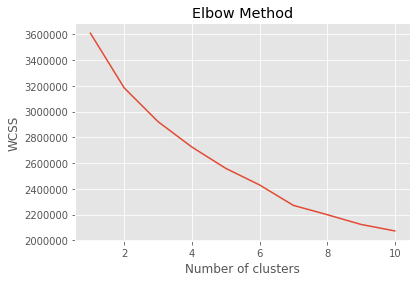

In [21]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X_train)
X_train = pd.DataFrame(scaled_df, columns=X_train.columns)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans = kmeans.fit(X_train)
labels = kmeans.predict(X_train)
C = kmeans.cluster_centers_

y_pred_kmeans = kmeans.predict(X_test)


 <p><a name="decision"></a></p>
 
 ### Decision Tree 

Model Accuracy: 0.9999985255190266
Test Accuracy: 0.9822914900361985
[[333117   6048]
 [  5962 333078]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    339165
           1       0.98      0.98      0.98    339040

    accuracy                           0.98    678205
   macro avg       0.98      0.98      0.98    678205
weighted avg       0.98      0.98      0.98    678205



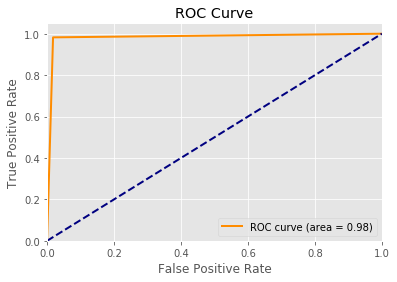

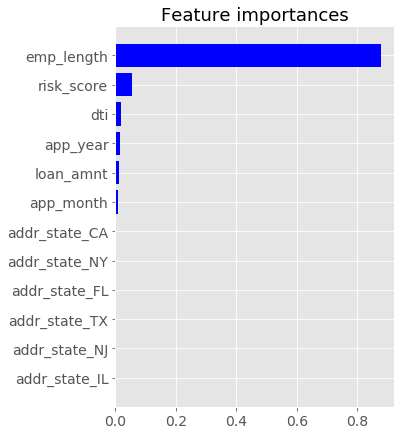

In [10]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

print(f'Model Accuracy: {tree.score(X_train, y_train)}')

y_pred = tree.predict(X_test)
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred))
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))




y_predict_probabilities = tree.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

features = X_train.columns
importance = tree.feature_importances_

indices = np.argsort(importance)[-12:]
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="b",  align="center")
plt.tick_params(labelsize=14);

 <p><a name="rf"></a></p>
 
 ### Random Forest

Model Accuracy: 0.972055267970329
Test Accuracy: 0.9717002971078066
[[338972    193]
 [ 19000 320040]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97    339165
           1       1.00      0.94      0.97    339040

    accuracy                           0.97    678205
   macro avg       0.97      0.97      0.97    678205
weighted avg       0.97      0.97      0.97    678205



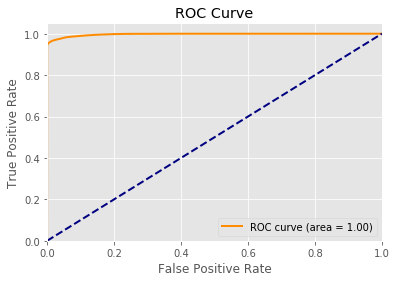

In [11]:

from sklearn.ensemble import RandomForestClassifier

# Create the model with 1000 trees
rand = RandomForestClassifier(n_estimators=100, max_depth=10, n_jobs=-1, random_state=0)

# Fit on training data
rand.fit(X_train, y_train)
y_pred_rand = rand.predict(X_test)

print(f'Model Accuracy: {rand.score(X_train, y_train)}')
print("Test Accuracy:",metrics.accuracy_score(y_test, y_pred_rand))

from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred_rand)
print(confusion_matrix)
print(classification_report(y_test, y_pred_rand))

# Actual class predictions
rf_predictions = rand.predict(X_test)
# Probabilities for each class
rf_probs = rand.predict_proba(X_test)[:, 1]

# Calculate roc auc
roc_value = roc_auc_score(y_test, rf_probs)
roc_value


features = X_train.columns
importance = rand.feature_importances_

indices = np.argsort(importance)[-12:]
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="b",  align="center")
plt.tick_params(labelsize=14);



from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

y_predict_probabilities = rand.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, y_predict_probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#random search grid search
from sklearn.metrics import make_scorer, accuracy_score
clf = RandomForestClassifier()

parameters = {'n_estimators': [800,1200,1600,2400], 
              'max_features': [2,4,5,6], 
              'criterion': [ 'gini'],
              'max_depth': [4,10,15,20], 
              'min_samples_split': [2,4,5,7],
              'min_samples_leaf': [1,2,4,6]
             }

acc_scorer = make_scorer(accuracy_score)

grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(X_train, y_train)
best_est = grid_obj.best_estimator_
print (best_est)



In [ ]:
print(f'Model Accuracy: {grid_obj.score(X_train, y_train)}')
y_pred_random = grid_obj.predict(X_test)
print('test accuracy:',accuracy_score(y_test, y_pred_random))



In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred_random)
print(confusion_matrix)
print(classification_report(y_test, y_pred_random))



In [ ]:
features = X_train.columns
importance = best_est.feature_importances_
indices = np.argsort(importance)[-12:]
plt.figure(figsize=(5, 7))
plt.title("Feature importances", fontsize = 18)
plt.barh(features[indices], importance[indices],
       color="b",  align="center")
plt.tick_params(labelsize=14)

 <p><a name="svm"></a></p>
 
 ### SVM

In [ ]:
svc = LinearSVC()
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)


from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred_svc)
print(confusion_matrix)
print(classification_report(y_test, y_pred_svc))


In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_svc)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#### SVM Grid Search

param_grid = {'C':[1,10,100,1000], 'penalty':['l2'], 'loss':['hinge']}
grid_svm = GridSearchCV(LinearSVC(),param_grid,refit = True, verbose=2)


grid_svm.fit(X_train,y_train)

best_est_svc = grid_svm.best_estimator_
print (best_est_svc)


In [ ]:
print(f'Model Accuracy: {grid_svm.score(X_train, y_train)}')
y_pred_svc = grid_svm.predict(X_test)
print('test accuracy:',accuracy_score(y_test, y_pred_svc))


In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred_svc)
print(confusion_matrix)
print(classification_report(y_test, y_pred_svc))

 <p><a name="xgboost"></a></p>
 
 ### XGBoost

In [ ]:
import xgboost as xgb
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)
param = {
    'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',  
    'num_class': 2} 

steps = 20  # The number of training iterations

model = xgb.train(param, D_train, steps)
preds_xg = model.predict(D_test)
best_preds_xg = np.asarray([np.argmax(line) for line in preds_xg])

print("Precision = {}".format(precision_score(y_test, best_preds_xg, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds_xg, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds_xg)))


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, best_preds_xg)
print(confusion_matrix)
print(classification_report(y_test, best_preds_xg))


In [ ]:
#grid search xg boost
clf = xgb.XGBClassifier()

parameters = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }

grid = GridSearchCV(clf,
                    parameters, n_jobs=4,
                    scoring="neg_log_loss",
                    cv=3)

grid.fit(X_train, y_train)

preds = grid.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))



In [ ]:
confusion_matrix = confusion_matrix(y_test, best_preds)
print(confusion_matrix)
print(classification_report(y_test, best_preds))


 <p><a name="logistic"></a></p>
 
 ### Logistic Regression
 
- Links: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, logreg.predict(X_test))

print(confusion_matrix)

print(classification_report(y_test, y_pred))

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


## Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
model_naive = GaussianNB()

# Train the model using the training sets
model_naive.fit(X_train, y_train)

#Predict Output
y_pred_naive = model_naive.predict(X_test) 
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred_naive)
print(confusion_matrix)
print(classification_report(y_test, y_pred_naive))

# logit_roc_auc = roc_auc_score(y_test, y_pred_naive)
# fpr, tpr, thresholds = roc_curve(y_test, y_pred_naive[:,1])
# plt.figure()
# plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.savefig('Log_ROC')
# plt.show()

### Nearest Neighbor

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
X_train_scaler  = scaler.fit_transform(X_train)
X_test_scaler  = scaler.fit_transform(X_test)
# from sklearn.decomposition import PCA



from sklearn.neighbors import KNeighborsClassifier

k = 2

knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train_scaler, y_train) 
y_pred = knn_model.predict(X_test_scaler)
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
print(classification_report(y_test, y_pred))
